# ML methods applied to microbiome data

by Georg Zeller, EMBL Heidelberg, Germany (2016)


This tutorial aims at illustrating how various machine learning methods can be applied to associate gut microbiome composition (that is abundance profiles of various microbial species dwelling in our guts) with host 'phenotypes', using colorectal cancer as an example here. We will use data from [Zeller et al. Mol Syst Biol., 2014](http://onlinelibrary.wiley.com/doi/10.15252/msb.20145645/abstract), where the context and motivation is also explained in more detail. Here the focus will be on technical aspects and we will explore a variety of machine learning techniques (not just LASSO).

For the analysis of gut microbiome associations with host states, machine learning approaches nicely complement univariate tests for associations of single microbes with host state and multivariate ordination-based techniques, such as PCA and PCoA for the following reasons:

- Trained models allow us to make predictions, the accuracy of which can be evaluated using ROC or precision-recall analysis; this is relevant for the development of microbiome-based diagnostic tests (e.g. for colorectal cancer screening). Often evaluations of accuaracy are arguably more relevant measures of association strength than e.g. statistical significance.
- Sparse (e.g. regularized) statistical models offer a good trade-off between multivariate and univariate testing, as they're not just based on a single feature, but can pick up subtle associations that may be obscured by other sources of variation in multivariate analyses (e.g. PCA). They are thus useful for biomarker discovery (and used as such in other domains as well, e.g. genomics).

(A more empirical treatment is found in [Zeller et al. Mol Syst Biol., 2014](http://onlinelibrary.wiley.com/doi/10.15252/msb.20145645/abstract).)

Here we will investigate two main aspects:

- Prediction: How does generalization accuracy depend on the combination of learning method and data preprocessing?
- Inference: What are the statistical models based on and how can we visualize the result of feature selection? (We are thus focusing on 'white box' approaches here.) 

### Preparation of packages and data

In [5]:
# ML R packages
#install.packages('glmnet')
#install.packages('LiblineaR')
#install.packages('randomForest')
#install.packages('gelnet')
#install.packages('pROC')
library('glmnet')       # for LASSO and Elastic Net
library('LiblineaR')    # for alternative L1- & L2-penalized models (including SVMs)
library('randomForest') # for Random Forest
library('gelnet')       # for a variant of elastic net
library('pROC')         # for evaluations / ROC curves

In [6]:
# resize plots in Jupyter Notebook to more convenient dimensions
options(repr.plot.width=5, repr.plot.height=5)

In [7]:
# use the following command to get packages from within a Jupyter notebook
#install.packages('gelnet', repos="http://cran.us.r-project.org")

In [8]:
# initialize random number generator to a defined state to ensure reproducibility
set.seed(2016)

We will be using a subset of the data described in [Zeller et al. Mol Syst Biol., 2014](http://onlinelibrary.wiley.com/doi/10.15252/msb.20145645/abstract) (the FR-CRC-... data set) and try to classify study participants into colorectal cancer (CRC) patients and controls based on their gut (fecal) microbiome profiled with shotgun metagenomics. The other data set (for additional exploration) is based on similarly preprocessed metagenomic sequencing data from [Feng et al. Nat Commun., 2015](http://www.nature.com/ncomms/2015/150311/ncomms7528/abs/ncomms7528.html).


In [9]:
# Input data (a subset of what is described in the paper)

fn.feat <- 'http://www.bork.embl.de/~zeller/mlbc_data/FR-CRC_N114_feat_specIclusters.tsv'
fn.label <- 'http://www.bork.embl.de/~zeller/mlbc_data/FR-CRC_N114_label.tsv'
#fn.feat <- 'http://www.bork.embl.de/~zeller/mlbc_data/AT-CRC_N109_feat_specIclusters.tsv'
#fn.label <- 'http://www.bork.embl.de/~zeller/mlbc_data/AT-CRC_N109_label.tsv'

# load label data and convert it into vector with names (mind R's defaults...)
label <- read.table(fn.label, quote='', sep='\t', header=FALSE, row.names=1,
                    check.names=FALSE)
lab <- label[,1]
names(lab) <- rownames(label)
label <- lab

# read feature matrix
feat <- read.table(fn.feat, quote='', sep='\t', header=TRUE, row.names=1,
                   check.names=FALSE)
feat <- as.matrix(feat)
stopifnot(all(names(label) == colnames(feat)))

cat('Loaded data: n = ', ncol(feat), ' observations (samples), each with p = ', 
                         nrow(feat), ' variables (features).\n', sep='')



Loaded data: n = 114 observations (samples), each with p = 1754 variables (features).


### Basic characterization of the data
- Features: typical read count data, a p x n matrix of predictors containing n samples in the columns and in the rows p microbial species abundance features estimated based on metagenomic reads assigned to certain marker genes (see Zeller et al. Mol Syst Biol., 2014 and references therein for details).
- Labels: a vector containing the response variable (patient group), where +1 indicates a CRC case, and -1 a control.

Below we will explore some basic properties of the feature data, such as library size and read count distributions for some species.

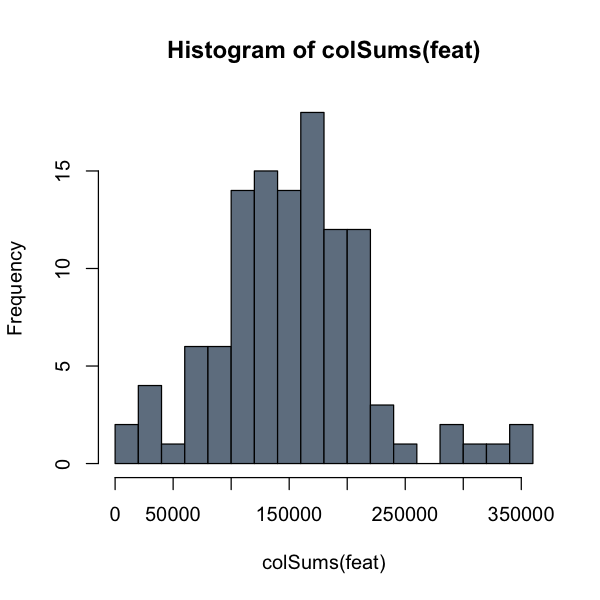

In [10]:
# library sizes
hist(colSums(feat), 20, col='slategray')

### Data preprocessing I - library size rescaling and low-abundance filtering
The above plots strongly suggests to correct for differences in library size. Here we use the simplest approach: conversion to relative abundances (aslo known as total sum scaling). Alternatives are rarefying (i.e. downsampling) or DESeq's library size normalization...

We also discard features with very low abundance in all samples. This is a heuristic motivated by the common believe that these are unlikely to play a major role in the gut ecosystem and their quantification has the greatest uncertainty.


In [11]:
# conversion to relative abundances (a simple type of library size normalization)
feat <- prop.table(feat, 2)

cat('Converted read count data to relative abundances.\n')

Converted read count data to relative abundances.


In [12]:
# unsupervised feature filtering
abundance.cutoff <- 1E-3
f.max <- apply(feat, 1, max)
f.idx <- which(f.max >= abundance.cutoff)
cat('Number of features before filtering:', nrow(feat), '\n')
feat <- feat[f.idx,]
if (rownames(feat)[1] == 'UNMAPPED' || rownames(feat)[1] == '-1') {
  feat <- feat[-1,]
}
cat('Number of features after filtering:', nrow(feat), '\n')


Number of features before filtering: 1754 
Number of features after filtering: 207 


### Further characterization of the filtered feature data (in relative abundance space)

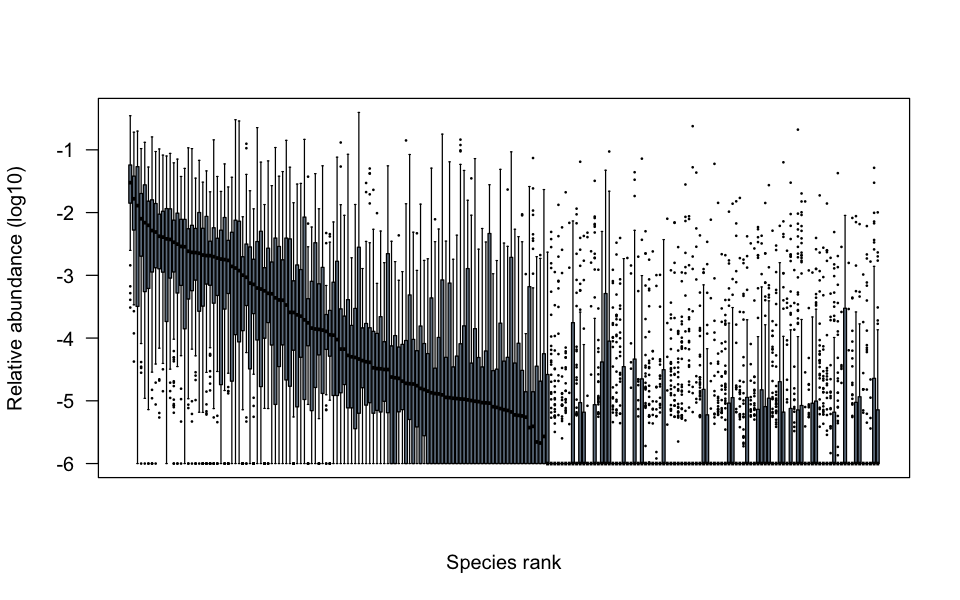

In [13]:
# resize plots in Jupyter Notebook to more convenient dimensions
options(repr.plot.width=8, repr.plot.height=5)

# rank-abundance plot
rnk <- order(apply(feat, 1, median), decreasing=TRUE)
boxplot(log10(t(feat[rnk,]) + 1E-6), las=2, cex=0.3, pch=16, lty=1,
        col='slategray', 
        xlab='Species rank', ylab='Relative abundance (log10)', xaxt='n')

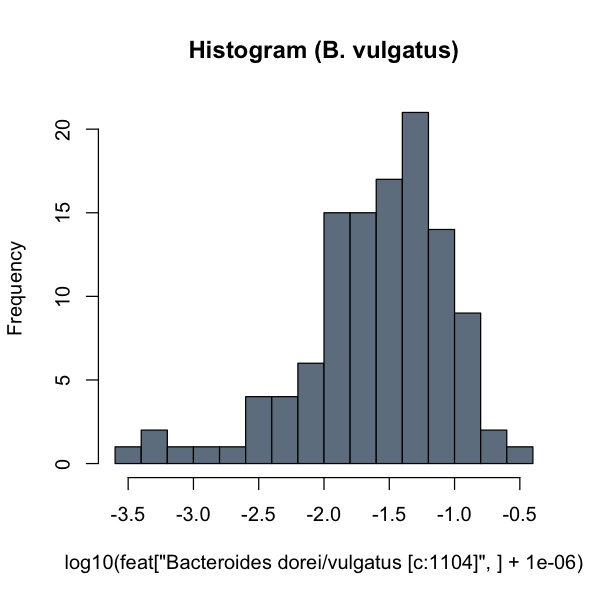

In [14]:
# resize plots in Jupyter Notebook to more convenient dimensions
options(repr.plot.width=5, repr.plot.height=5)

# one of the most abundant species
hist(log10(feat['Bacteroides dorei/vulgatus [c:1104]',] + 1E-6), 20,
     col='slategray', main='Histogram (B. vulgatus)')

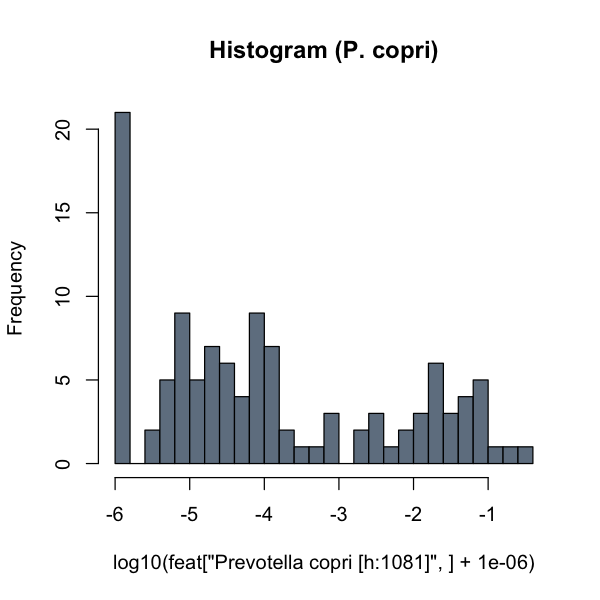

In [15]:
# a species with lower prevalence
hist(log10(feat['Prevotella copri [h:1081]',] + 1E-6), 20,
     col='slategray', main='Histogram (P. copri)')

### Data preprocessing II - normalization
We are exploring several normalization approaches here. Importantly, they do not make use label information (patient status), and can thus be applied outside of the following cross validation.

Although preprocessing methods are largely heuristic in nature, the following and similar approaches are widely used and often largely determine model quality, as discussed later. 

In [16]:
# unsupervised feature normalization
norm.method <- 'log.std' # 'std', 'log.std', 'log.center', log.unit' or NULL

if (!is.null(norm.method)) {
  n0 <- 10^-6      # 'offset' for log transformation
  sd.min.q <- 0    # small 'shrinkage' parameter for (almost) invariant features
  if (norm.method == 'std') {
    # 'classical' standardization
    m <- apply(feat, 1, mean)
    s <- apply(feat, 1, sd)
    q <- ifelse(sd.min.q <= 0, 0, quantile(s, sd.min.q, names=FALSE))
    for (r in 1:ncol(feat)) {
      feat[r,] <- (feat[r,] - m[r]) / (s[r] + q)
    }
  } else if (norm.method == 'log.std') {
    # logarithmic transformation followed by standardization
    feat <- log10(feat + n0)
    m <- apply(feat, 1, mean)
    s <- apply(feat, 1, sd)
    q <- ifelse(sd.min.q <= 0, 0, quantile(s, sd.min.q, names=FALSE))
    for (r in 1:ncol(feat)) {
      feat[r,] <- (feat[r,] - m[r]) / (s[r] + q)
    }
  } else if (norm.method == 'log.center') {
    # logarithmic transformation followed by mean centering
    feat <- log10(feat + n0)
    m <- apply(feat, 1, mean)
    for (r in 1:ncol(feat)) {
      feat[r,] <- feat[r,] - m[r]
    }
  } else {
    stop('unknown normalization method')
  }
  stopifnot(!any(is.na(feat)))
}

cat('Normalized', nrow(feat), 'features using the',
    norm.method, 'method.\n')


Normalized 207 features using the log.std method.


### Preparation of cross-validation (CV) data splits
We will use the function below to partition data into cross validation folds for external CV as well as for internal model selection.


In [17]:
# this function returns a subset identifier for each example drawn at random from [1, num.folds]
# use num.folds=10 for ten-fold cross validation
# if stratified=TRUE, subsets will have approximately the same balance of positive and negative examples
partition.data <- function(label, num.folds=10, stratified=FALSE) {
  # this will be 
  fold.id <- rep(0, length(label))

  if (stratified) {
    classes <- unique(label)
    for (c in classes) {
      urn <- rep(1:num.folds, ceiling(sum(label==c) / num.folds))
      s <- sample(urn, sum(label==c))
      fold.id[label==c] <- s
    }
  } else {
    # this gives more equally sized subsets than just sampling from 1:num.folds
    fold.id <- sample(rep(1:num.folds, length.out=length(label)))
  }
  stopifnot(all(fold.id > 0))
  stopifnot(length(label) == length(fold.id))
    
  return(fold.id)
}

### Prepare a general training / test interface to the various ML methods

The code below provides a common interface to several machine learning methods from various R packages to facilitate their use in a general (largely package-independent) framework.

In [18]:
# function to fit models
train <- function(feat, label, method, hyper.par) {
  method <- tolower(method)
  model <- list(original.model=NULL, feat.weights=NULL)
    
  # note that some of the logit models are set up inversely to each other,
  # requiring to swap coefficient signs

  if (method == 'lasso') {
    # here we will ignore any hyper.par$alpha to ensure a LASSO model (and not an Elastic Net) is trained
    lambda <- exp(seq(log(1), log(hyper.par$lambda), length.out=100))
    model$original.model <- glmnet(t(feat), factor(label, levels=c(+1, -1)),
                                   family='binomial', standardize=FALSE,
                                   alpha=1, lambda=lambda)
    c <- coefficients(model$original.model)
    c <- c[,ncol(c)]
    bias.idx <- which(names(c) == '(Intercept)')
    model$feat.weights <- as.numeric(c[-bias.idx])

  } else if (method == 'lasso_ll') {
    liblin.type <- 6
    model$original.model <- LiblineaR(t(feat), label, 
                                      type=liblin.type, bias=TRUE, epsilon=1e-6,
                                      cost=hyper.par$C)
    bias.idx <- which(colnames(model$original.model$W) == 'Bias')
    model$feat.weights <- as.numeric(-1 * model$original.model$W[,-bias.idx])

  } else if (method == 'ridge_ll') {
    liblin.type <- 0
    model$original.model <- LiblineaR(t(feat), label, 
                                      type=liblin.type, bias=TRUE, epsilon=1e-6,
                                      cost=hyper.par$C)
    bias.idx <- which(colnames(model$original.model$W) == 'Bias')
    model$feat.weights <- as.numeric(-1 * model$original.model$W[,-bias.idx])

  } else if (method == 'enet') {
    stopifnot(hyper.par$alpha < 1) # otherwise we're going to train a LASSO model
    lambda <- exp(seq(log(1),log(hyper.par$lambda),length.out=100))
    model$original.model <- glmnet(t(feat), factor(label, levels=c(+1, -1)),
                                   family='binomial', standardize=FALSE,
                                   alpha=hyper.par$alpha, lambda=lambda)
    c <- coefficients(model$original.model)
    c <- c[,ncol(c)]
    bias.idx <- which(names(c) == '(Intercept)')
    model$feat.weights <- as.numeric(c[-bias.idx])    

  } else if (method == 'gelnet') {
    stopifnot(hyper.par$alpha < 1) # otherwise we're going to train a LASSO model
    model$original.model <- gelnet(t(feat), factor(label, levels=c(+1, -1)),
                                   l2=hyper.par$alpha, l1=hyper.par$lambda,
                                   silent=TRUE)
    # for consistency with the other models the coeeficient sign needs to be flipped
    model$feat.weights <- -1.0 * model$original.model$w

  } else if (method == 'l1_svm') {
    liblin.type <- 5
    model$original.model <- LiblineaR(t(feat), label, 
                                      type=liblin.type, bias=TRUE, epsilon=1e-6,
                                      cost=hyper.par$C)
    bias.idx <- which(colnames(model$original.model$W) == 'Bias')
    model$feat.weights <- as.numeric(-1 * model$original.model$W[,-bias.idx])

  } else if (method == 'l2_svm') {
    liblin.type <- 1
    model$original.model <- LiblineaR(t(feat), label, 
                                      type=liblin.type, bias=TRUE, epsilon=1e-6,
                                      cost=hyper.par$C)
    bias.idx <- which(colnames(model$original.model$W) == 'Bias')
    model$feat.weights <- as.numeric(-1 * model$original.model$W[,-bias.idx])

  } else if (method == 'rf') {
      model$original.model <- randomForest(t(feat), factor(label, levels=c(+1, -1)), 
                                           ntree=hyper.par$ntree, mtry=hyper.par$mtry,
                                           importance=TRUE)
      # the third column of RF's feature importance matrix contains 
      # class-independent mean decrease in accuracy
      model$feat.weights <- model$original.model$importance[,3]

  } else {
    stop('unknown method')
  }
  
  return(model)
}


# function to apply fitted models to make predictions
# note that many packages come with pre-implemented CVs, which are more efficient than the generic version used here
test <- function(feat, model, method, opt.hyper.par) {
  method <- tolower(method)

  # note that some of the logit models are set up inversely to each other,
  # requiring to select coefficient/prediction columns accordingly using col.idx 
  if (method == 'lasso') {
      col.idx <- 1
      # glmnet's predict function needs to be given a lambda value 
      pred <- predict(model$original.model, t(feat),
                      alpha=1, s=opt.hyper.par$lambda,
                      type="response")[,col.idx]

  } else if (method == 'lasso_ll' || method == 'ridge_ll') {
      col.idx <- 2 # this is a bit counter-intuitive given the column names of the predict data frame
      pred <- predict(model$original.model, t(feat), 
                          proba=TRUE)$probabilities[,col.idx]

  } else if (method == 'enet') {
      col.idx <- 1
      # glmnet's predict function needs to be given a lambda value 
      pred <- predict(model$original.model, t(feat),
                      alpha=opt.hyper.par$alpha, s=opt.hyper.par$lambda,
                      type="response")[,col.idx]

  } else if (method == 'gelnet') {
      # gelnet's predictions need to be calculated "by hand"
      m <- model$original.model
      pred <- 1.0 / (1.0 + exp(t(feat) %*% m$w + m$b))

  } else if (method == 'l1_svm' || method == 'l2_svm') {
      col.idx <- 1
      pred <- predict(model$original.model, t(feat), 
                          decisionValues=TRUE)$decisionValues[,col.idx]

  } else if (method == 'rf') {
      col.idx <- 1
      # this will give class "probabilities" rather than class assignments
      pred <- predict(model$original.model, t(feat), type='prob')[,col.idx]

  } else {
    stop('unknown method')
  }
  return(pred)
}


# function to perform model selection. e.g. 'tune' hyperparameters
select.model <- function(feat, label, method, hyper.par,
                         num.folds=5, stratified=FALSE) {
  method <- tolower(method)
  opt.hyper.par <- NULL

  # here we use the area under the ROC curve as a model selection criterion,
  # but there are alternatives (e.g. accuracy, partial AU-ROC or the area under the precision-recall curve)

  fold.id <- partition.data(label, num.folds, stratified)
  p <- rep(NA, length(label))

  if (method == 'lasso') {
    aucs <- rep(0, length(hyper.par$lambda))
    for (i in 1:length(hyper.par$lambda)) {
      hp <- NULL
      hp$lambda <- hyper.par$lambda[i]
      for (f in 1:num.folds) {
        test.idx <- which(fold.id == f)
        train.idx <- setdiff(1:length(label), test.idx)

        model <- train(feat[,train.idx], label[train.idx], method, hp)
        p[test.idx] <- test(feat[,test.idx], model, method, hp)
      }
      aucs[i] <- roc(response=label, predictor=p)$auc
      cat('    ', method, ' model selection: (lambda=', hyper.par$lambda[i],
          ') AU-ROC=', format(aucs[i], digits=3), '\n', sep='')
    }
    opt.idx <- which.max(aucs)
    opt.hyper.par$lambda <- hyper.par$lambda[opt.idx]
    cat('    optimal lambda =', hyper.par$lambda[opt.idx], '\n') 

  } else if (method == 'lasso_ll' || method == 'ridge_ll' || method == 'l1_svm' || method == 'l2_svm') {
    aucs <- rep(0, length(hyper.par$C))
    for (i in 1:length(hyper.par$C)) {
      hp <- NULL
      hp$C <- hyper.par$C[i]
      for (f in 1:num.folds) {
        test.idx <- which(fold.id == f)
        train.idx <- setdiff(1:length(label), test.idx)

        model <- train(feat[,train.idx], label[train.idx], method, hp)
        p[test.idx] <- test(feat[,test.idx], model, method, hp)
      }
      aucs[i] <- roc(response=label, predictor=p)$auc
      cat('    ', method, ' model selection: (C=', hyper.par$C[i],
          ') AU-ROC=', format(aucs[i], digits=3), '\n', sep='')
    }
    opt.idx <- which.max(aucs)
    opt.hyper.par$C <- hyper.par$C[opt.idx]
    cat('    optimal C =', hyper.par$C[opt.idx], '\n') 

  } else if (method == 'enet' || method == 'gelnet') {
    aucs <- matrix(0, nrow=length(hyper.par$alpha),
                   ncol=length(hyper.par$lambda))
    for (i in 1:length(hyper.par$alpha)) {
      for (j in 1:length(hyper.par$lambda)) {
        hp <- NULL
        hp$alpha <- hyper.par$alpha[i]
        hp$lambda <- hyper.par$lambda[j]
        for (f in 1:num.folds) {
          test.idx <- which(fold.id == f)
          train.idx <- setdiff(1:length(label), test.idx)

          model <- train(feat[,train.idx], label[train.idx], method, hp)
          p[test.idx] <- test(feat[,test.idx], model, method, hp)
        }
        aucs[i,j] <- roc(response=label, predictor=p)$auc
        cat('    ', method, ' model selection: (alpha=', hyper.par$alpha[i], 
            ', lambda=', hyper.par$lambda[j], ') AU-ROC=', 
            format(aucs[i,j], digits=3), '\n', sep='')
      }
    }
    opt.idx <- arrayInd(which.max(aucs), dim(aucs))
    opt.hyper.par$alpha <- hyper.par$alpha[opt.idx[1]]
    opt.hyper.par$lambda <- hyper.par$lambda[opt.idx[2]]
    cat('    optimal alpha =' , hyper.par$alpha[opt.idx[1]], 
        ', lambda =', hyper.par$lambda[opt.idx[2]], '\n') 

  } else if (method == 'rf') {
    aucs <- matrix(0, nrow=length(hyper.par$ntree), 
                   ncol=length(hyper.par$mtry))
    for (i in 1:length(hyper.par$ntree)) {
      for (j in 1:length(hyper.par$mtry)) {
        hp <- NULL
        hp$ntree <- hyper.par$ntree[i]
        hp$mtry <- hyper.par$mtry[j]
        for (f in 1:num.folds) {
          test.idx <- which(fold.id == f)
          train.idx <- setdiff(1:length(label), test.idx)

          model <- train(feat[,train.idx], label[train.idx], method, hp)
          p[test.idx] <- test(feat[,test.idx], model, method, hp)
        }
        aucs[i,j] <- roc(response=label, predictor=p)$auc
        cat('    ', method, ' model selection: (ntree=', 
            hyper.par$ntree[i], ', mtry=', hyper.par$mtry[j], ') AU-ROC=', 
            format(aucs[i,j], digits=3), '\n', sep='')
      }
    }
    opt.idx <- arrayInd(which.max(aucs), dim(aucs))
    opt.hyper.par$ntree <- hyper.par$ntree[opt.idx[1]]
    opt.hyper.par$mtry <- hyper.par$mtry[opt.idx[2]]
    cat('    optimal ntree =' , hyper.par$ntree[opt.idx[1]], 
        ', mtry =', hyper.par$mtry[opt.idx[2]], '\n') 

  } else {
    stop('unknown method')
  }
  return(opt.hyper.par)
}

cat('Initialized training, testing and cross-validation framework.\n')


Initialized training, testing and cross-validation framework.


### Set up the (external) cross validation (CV) for the assessment of model accuracy

To ensure a fair comparison between methods, the same data partitions (subsets) will be used throughout.

In [19]:
# here we use 5-fold, stratified cross-validation
num.folds <- 5
fold.id <- partition.data(label, num.folds, stratified=TRUE)

cat('Prepared', num.folds, 'folds for cross validation.\n')
print(table(label, fold.id))


Prepared 5 folds for cross validation.
     fold.id
label  1  2  3  4  5
   -1 12 12 12 12 13
   1  10 11 10 11 11


### Train and apply various methods

In [20]:
# machine learning methods to be investigated
ml.methods <- c('LASSO_LL', 'LASSO',
                'ENet',
                'GElNet',
                'Ridge_LL',
                'RF',
                'L1_SVM',
                'L2_SVM')
# one color for each method
m.cols <- c('#FF7F00', '#CD2626','#009ACD', '#483D8B', '#006400', '#76EE00', '#505050', '#A0A0A0')
m.cols <- paste0(m.cols, 'B0') # add transparency

# initialize a range of hyper parameters for each method to be explored in model selection
sqrt.mdim <- sqrt(nrow(feat))
hyper.par <- list(C      = c(0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10), # all LiblineaR methods
                  lambda = c(0.001, 0.003, 0.01, 0.03, 0.1, 0.3),           # LASSO & ENet
                  alpha  = c(0.7,0.8,0.9),                                  # ENet
                  ntree  = c(250, 500, 1000),                               # RF
                  mtry   = c(sqrt.mdim/2, sqrt.mdim, sqrt.mdim*2))          # RF

# we will collect CV test predictions,
pred <- list()
# corresponding AU-ROC values
aucs <- list()
# and the corresponding 'feature weights' from the models
feat.weigths <- list()


# loop over methods
for (m in 1:length(ml.methods)) {
  # loop over CV folds
  cat('Cross validating', ml.methods[m], '\n')

  # for method-specific test predictions and feature weights
  p <- rep(NA, length(label))
  fw <- matrix(0, nrow=nrow(feat), ncol=num.folds)

  for (f in 1:num.folds) {
    test.idx <- which(fold.id==f)
    train.idx <- setdiff(1:length(label), test.idx)
      
    train.feat <- feat[,train.idx]
    train.label <- label[train.idx]
    test.feat <- feat[,test.idx]
    test.label <- label[test.idx]
    cat('  fold', f, '\n')

    # internal CV for model selection (aka hyper-parameter tuning)
    opt.hyper.par <- select.model(train.feat, train.label, ml.methods[m], 
                                  hyper.par, num.folds=5, stratified=TRUE)
    
    # fit a model with optimal hyper-parameters
    model <- train(train.feat, train.label, ml.methods[m], opt.hyper.par)
    fw[,f] <- model$feat.weights

    # apply the model on test partition
    p[test.idx] <- test(test.feat, model, ml.methods[m], opt.hyper.par)
  }
  # evaluate cross-validation predictions
  r <- roc(response=label, predictor=p)

  # collect test predictions, AU-ROC and feature weights for all methods
  aucs[[ ml.methods[m] ]] <- as.numeric(r$auc)
  pred[[ ml.methods[m] ]] <- as.numeric(p)
  feat.weigths[[ ml.methods[m] ]] <- fw
}


Cross validating LASSO_LL 
  fold 1 
    lasso_ll model selection: (C=0.001) AU-ROC=0.5
    lasso_ll model selection: (C=0.003) AU-ROC=0.5
    lasso_ll model selection: (C=0.01) AU-ROC=0.5
    lasso_ll model selection: (C=0.03) AU-ROC=0.5
    lasso_ll model selection: (C=0.1) AU-ROC=0.845
    lasso_ll model selection: (C=0.3) AU-ROC=0.897
    lasso_ll model selection: (C=1) AU-ROC=0.889
    lasso_ll model selection: (C=3) AU-ROC=0.893
    lasso_ll model selection: (C=10) AU-ROC=0.895
    optimal C = 0.3 
  fold 2 
    lasso_ll model selection: (C=0.001) AU-ROC=0.5
    lasso_ll model selection: (C=0.003) AU-ROC=0.5
    lasso_ll model selection: (C=0.01) AU-ROC=0.5
    lasso_ll model selection: (C=0.03) AU-ROC=0.5
    lasso_ll model selection: (C=0.1) AU-ROC=0.738
    lasso_ll model selection: (C=0.3) AU-ROC=0.74
    lasso_ll model selection: (C=1) AU-ROC=0.732
    lasso_ll model selection: (C=3) AU-ROC=0.736
    lasso_ll model selection: (C=10) AU-ROC=0.734
    optimal C = 0.3 
  fold 3

Some observations / notes on the above:
- Some methods are more, others less, robust to the choice of hyper-parameters (most methods do need tuning).
- The hyper-parameter values chosen in the (internal) CV for model selection are not necessarily the same across folds.
- It is important to note that the choice of hyper-parameter in some cases determines the sparsity of the model (see below).
- SVMs do not return class probabilities, but a projection on the normal vector of the decision hyperplane -- however, for different C's, these may live on very different scales. Thus computing a ROC curve from concatenated test predictions has its issues (converting these to probabilities requires additional test data though).

### Evaluate CV accuracy

 LASSO_LL     LASSO      ENet    GElNet  Ridge_LL        RF    L1_SVM    L2_SVM 
0.8425611 0.8029694 0.7936901 0.8434890 0.8020414 0.8693164 0.8131766 0.8119394 


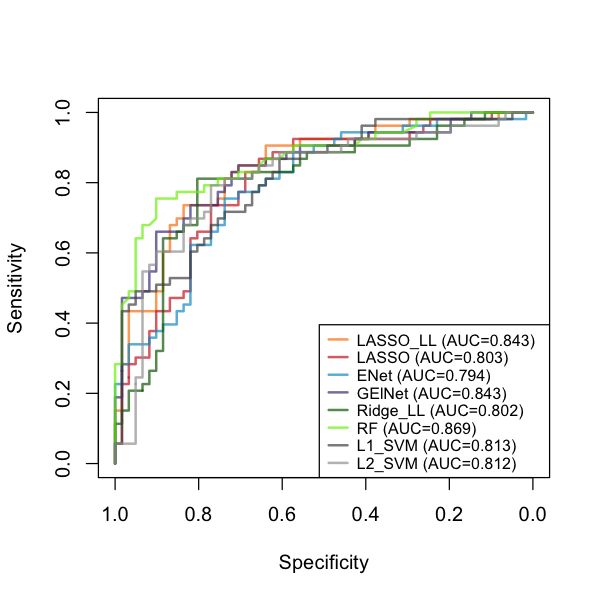

In [21]:
# plot ROC curves
plot(NULL, type='n', xlim=c(1,0), ylim=c(0,1) ,
     xlab='Specificity', ylab='Sensitivity')
for (m in 1:length(ml.methods)) {
  roc(response=label, predictor=pred[[ ml.methods[m] ]],
     plot=TRUE, add=TRUE, col=m.cols[m], lwd=2)
}
legend('bottomright', legend=paste(ml.methods, 
            ' (AUC=' , format(unlist(aucs), digits=3), ')', sep=''), 
       col=m.cols, lty=1, lwd=2, cex=0.8, y.intersp=1.5, text.width=0.45)

print(unlist(aucs))

### Visualize models (inference)
Below we visualize the feature weights assigned by the different models and compare them. For simplicity, we average the coefficients across cross-validated models, but one could also use, e.g., the median or additionally plot confidence intervals. The plots below are useful to assess not only the agreement between methods, but also their sparsity.

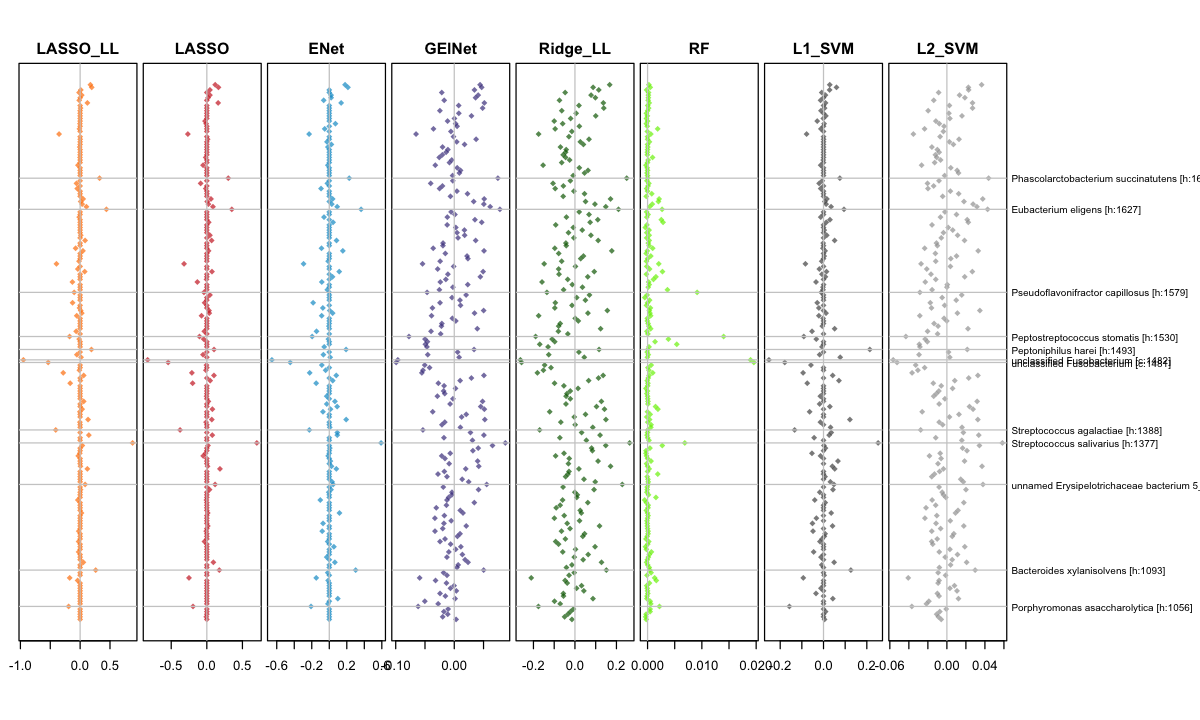

In [22]:
# resize plots in Jupyter Notebook to more convenient dimensions
options(repr.plot.width=10, repr.plot.height=6)

# extract some of the top features
n.top <- 5
top.f.idx <- NULL
for (m in 1:length(ml.methods)) {
  # we'll just average feature weights across CV models
  mean.weights <- rowMeans(feat.weigths[[ ml.methods[m] ]])
  top.f.idx <- union(top.f.idx,
                     which(rank(abs(mean.weights)) > nrow(feat) - n.top))
}

# feature weights plot
par(mfrow=c(1,length(ml.methods)))
par(oma=c(2,1,2,12))
par(mar=c(3,0.2,2,0.2))
for (m in 1:length(ml.methods)) {
  # we'll just average feature weights across CV models
  mean.weights <- rowMeans(feat.weigths[[ ml.methods[m] ]])
  plot(mean.weights, 1:nrow(feat),
       col=m.cols[m], pch=18,
       xlab='', ylab='', yaxt='n', main=ml.methods[m])
  abline(v=0, col='gray80')
  for(h in top.f.idx) {
    abline(h=h, col='gray80')
    if (m == length(ml.methods)) {
        mtext(rownames(feat)[h], side=4, at=h, las=2, cex=0.5, line=0.3)
    }
  }
}


### Exercises / Possible extensions

1. [Easy] Explore some of the other normalization methods (and / or filtering parameters) to investigate their effects on the resulting models (in terms of accuracy and feature selection). Investigate the effect of ommitting the log-transformation.
2. [Easy] Explore (visualize) how much the feature weights vary between cross-validation folds.
3. [Easy] Modify the model selection criterion, e.g. to a partial area under the curve (emphasizing the high-specificity region); hints can be found in the documentation of the pROC package.
4. Have a look pROC's capabilities of plotting confidence intervals around ROC curves and statistical tests for comparing them. Is any of the methods siginificantly more accurate than another?
5. Try to integrate your favorite machine learning method into the framework.
6. Apply the trained models to external (holdout test) data, e.g. the AT-CRC data set (see top of the notebook) and evaluate the accuracy. This should be straightforward with the provided functions except for normalization: the new data set should be normalized in the same way as the cross-validation data (this type of 'frozen normalization' requires saving and re-using the original normalization parameters).
7. [BIO] Run the above workflow on both the FR-CRC and the AT-CRC data sets and compare the top feature weights, e.g. the robustness of these as biomarkers for colorectal cancer.
8. [BIO] Run PCA and assess the 'global' separation of CRC patients and controls in the ordination plot. What is the resulting accuracy when principle components are used as features for machine learning?
9. [Hard] Non-sparse methods, such as RandomForests, Ridge Regression and L2 SVMs, can be 'shrunken' using external feature selection methods, e.g. Recursive Feature Elimination. Try to add one of these to the existing framework.
